In [1]:
current_dir = %pwd
image_dir = current_dir + '/../images'
result_dir = current_dir + '/../results'

In [2]:
from common import *
from scipy import stats
import os
import re
import json
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import *
from mpl_toolkits.mplot3d import Axes3D
%pylab inline
%matplotlib inline
#plt.style.use('ggplot')
print plt.style.available
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib
[u'grayscale', u'bmh', u'dark_background', u'ggplot', u'fivethirtyeight']


In [3]:
game_names = {
    'ms_pacman': 'Ms. Pacman',
    'space_invaders': 'Space Invaders',
    'freeway': 'Freeway',
    'pong': 'Pong',
    'seaquest': 'Seaquest',
}
exp_re= re.compile('(?P<experiment>.*?)' +
               '([_-]+rep.(?P<rep>[0-9]+))?' +
               '([_-]+(?P<date>[0-9]{2}-[0-9]{2}.*?))?$')

In [21]:
from scipy import stats

def process_results(results, num_reps=None, num_epochs=100):
    if num_reps is None:
        num_reps = len(results)
    rewards = np.empty((num_reps, num_epochs))
    qs = np.empty((num_reps, num_epochs))
    for rep in range(num_reps):
        results[rep]
        rewards[rep, ...] = results[rep]['reward_per_episode'][:num_epochs]
        qs[rep, ...] = results[rep]['mean_q'][:num_epochs]
    return rewards, qs
            
def process_results_for_games(results, games, num_reps=5, num_epochs=100):
    rewards = np.empty((num_games, num_reps, num_epochs))
    qs = np.empty((num_games, num_reps, num_epochs))
    for game_i, game in enumerate(games):
        rewards[game_i], qs[game_i] = process_results(results[game], num_reps, num_epochs)
    return rewards, qs

labelify = lambda labels: map(lambda l: l if int(l) < 1000 else str(int(l) / 1000) + 'k', labels)

In [13]:
single_base_dir = result_dir + '/single_frame'
single_learning, single_results, single_params = gather(single_base_dir)

phi_1-pong 


In [8]:
single_rewards, single_qs = process_results(single_results['phi_1-pong'])
single_rewards_err = stats.sem(single_rewards, axis=0)
single_rewards_mean = np.mean(single_rewards, axis=0)

## Frame Stacking

In [24]:
num_epochs = 100
num_reps = 5

base_boost_dir = result_dir + '/base_boost'
single_frame_boost_dir = result_dir + '/single_frame_boost'

base_boost_learning, base_boost_results, base_boost_params = gather(base_boost_dir)
single_boost_learning, single_boost_results, single_boost_params = gather(single_frame_boost_dir)

games = base_boost_results.keys()
num_games = len(games)

freeway ms_pacman pong seaquest space_invaders 
freeway ms_pacman pong seaquest space_invaders 


In [25]:
base_boost_rewards, base_boost_qs = process_results_for_games(base_boost_results, games)
single_boost_rewards, single_boost_qs = process_results_for_games(single_boost_results, games)

In [26]:
base_boost_rewards_err = stats.sem(base_boost_rewards, axis=1)
base_boost_rewards_mean = np.mean(base_boost_rewards, axis=1)
base_boost_rewards_max = np.max(base_boost_rewards, axis=1)
base_boost_rewards_min = np.min(base_boost_rewards, axis=1)
single_boost_rewards_err = stats.sem(single_boost_rewards, axis=1)
single_boost_rewards_mean = np.mean(single_boost_rewards, axis=1)

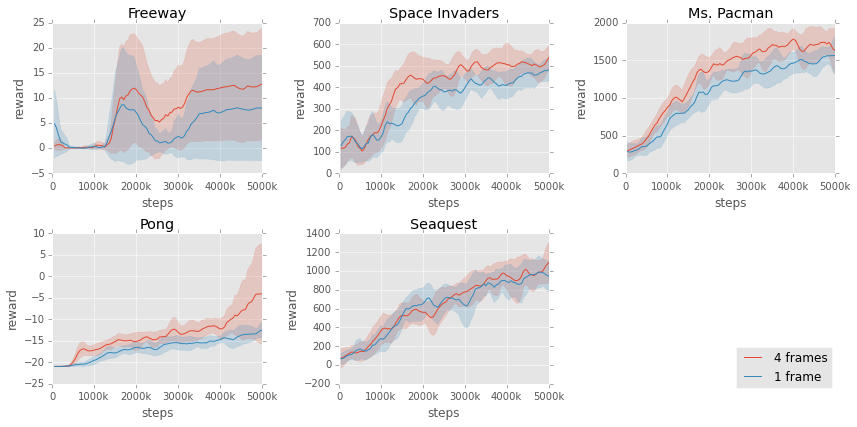

In [32]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)

fig = plt.figure(figsize=(12,6))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

lines = []
for game_i, game in enumerate(games):
    #base_ax = fig.add_subplot(num_games, 2, game_i * 2 + 1)
    #single_ax = fig.add_subplot(num_games, 2, game_i * 2 + 2)
    ax = fig.add_subplot(2, 3, game_i + 1)
    base_line, = ax.plot(steps, s(base_boost_rewards_mean[game_i]),
                        label='4 frames')
    ax.fill_between(steps, 
                    s(base_boost_rewards_mean[game_i]) - t * s(base_boost_rewards_err[game_i]),
                    s(base_boost_rewards_mean[game_i]) + t * s(base_boost_rewards_err[game_i]),
                    #base_boost_rewards_min[game_i],
                    #base_boost_rewards_max[game_i],
                    alpha=0.2,
                    color = base_line.get_color())
    single_line, = ax.plot(steps, smoothing(single_boost_rewards_mean[game_i], 5),
                          label='1 frame')
    ax.fill_between(steps, 
                s(single_boost_rewards_mean[game_i]) - t * s(single_boost_rewards_err[game_i]),
                s(single_boost_rewards_mean[game_i]) + t * s(single_boost_rewards_err[game_i]),
                alpha=0.2,
                color = single_line.get_color())
    ax.set_title(game_names[game])
    ax.set_xlabel('steps')
    ax.set_ylabel('reward')
    fig.canvas.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labelify(labels))
    
    lines += [base_line, single_line]

fig.legend(lines, labels=['4 frames', '1 frame'], bbox_to_anchor=(.97, 0.2))
fig.tight_layout()
plt.savefig(image_dir + '/stacked_vs_single.pdf')

## Late Fusion

## 3D Conv

In [114]:
conv3d_dir = result_dir + '/conv3d'

num_epochs = 100

conv3d_learning, conv3d_results, conv3d_params = gather(conv3d_dir)
conv3d = {k: process_results(v) for k, v in conv3d_results.iteritems()}
conv3d_rewards = {k: v[0] for k, v in conv3d.iteritems()}
conv3d_qs = {k: v[1] for k, v in conv3d.iteritems()}

for k,v in conv3d.iteritems():
    print k, '\t', v[0].shape

conv3d_10-pong conv3d_2_2_maxpool-pong conv3d_2_2_nopool-pong conv3d_2_3-pong conv3d_3_1-pong conv3d_3_2-pong conv3d_rgb-pong 
conv3d_3_2-pong 	(2, 100)
conv3d_3_1-pong 	(1, 100)
conv3d_10-pong 	(1, 100)
conv3d_rgb-pong 	(2, 100)
conv3d_2_2_nopool-pong 	(1, 100)
conv3d_2_2_maxpool-pong 	(1, 100)
conv3d_2_3-pong 	(2, 100)


In [115]:
conv3d_rewards_mean = {k: np.mean(v, axis=0) for k, v in conv3d_rewards.iteritems()}
conv3d_qs_mean = {k: np.mean(v, axis=0) for k, v in conv3d_qs.iteritems()}
conv3d_rewards_err = {k: stats.sem(v, axis=0) for k, v in conv3d_rewards.iteritems()}
conv3d_qs_err = {k: stats.sem(v, axis=0) for k, v in conv3d_qs.iteritems()}

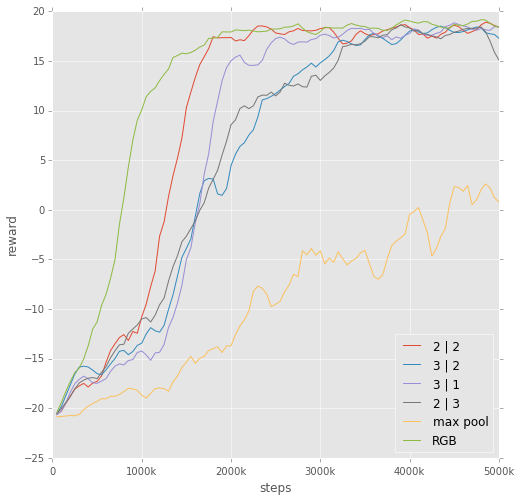

In [130]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)

fig = plt.figure(figsize=(8,8))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax = fig.add_subplot(111)
ax.plot(steps, s(conv3d_rewards_mean['conv3d_2_2_nopool-pong']),
       label='2 | 2')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_3_2-pong']),
       label='3 | 2')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_3_1-pong']),
       label='3 | 1')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_2_3-pong']),
       label='2 | 3')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_2_2_maxpool-pong']),
       label='max pool')
ax.plot(steps, s(conv3d_rewards_mean['conv3d_rgb-pong']),
       label='RGB')

fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labelify(labels))

ax.set_xlabel('steps')
ax.set_ylabel('reward')

plt.legend(loc='lower right')

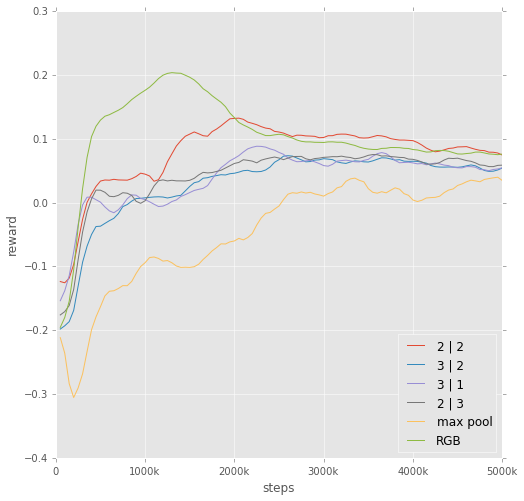

In [131]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)

fig = plt.figure(figsize=(8,8))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax = fig.add_subplot(111)
ax.plot(steps, s(conv3d_qs_mean['conv3d_2_2_nopool-pong']),
       label='2 | 2')
ax.plot(steps, s(conv3d_qs_mean['conv3d_3_2-pong']),
       label='3 | 2')
ax.plot(steps, s(conv3d_qs_mean['conv3d_3_1-pong']),
       label='3 | 1')
ax.plot(steps, s(conv3d_qs_mean['conv3d_2_3-pong']),
       label='2 | 3')
ax.plot(steps, s(conv3d_qs_mean['conv3d_2_2_maxpool-pong']),
       label='max pool')
ax.plot(steps, s(conv3d_qs_mean['conv3d_rgb-pong']),
       label='RGB')

fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labelify(labels))

ax.set_xlabel('steps')
ax.set_ylabel('reward')

plt.legend(loc='lower right')

## Late Fusion

In [132]:
late_fusion_dir = result_dir + '/late_fusion'

num_epochs = 100

late_fusion_learning, late_fusion_results, late_fusion_params = gather(late_fusion_dir)
late_fusion = {k: process_results(v) for k, v in late_fusion_results.iteritems()}
late_fusion_rewards = {k: v[0] for k, v in late_fusion.iteritems()}
late_fusion_qs = {k: v[1] for k, v in late_fusion.iteritems()}

for k,v in late_fusion.iteritems():
    print k, '\t', v[0].shape


late_fusion_4_noshare-pong late_fusion_4_share-pong 
late_fusion_4_share-pong 	(1, 100)
late_fusion_4_noshare-pong 	(1, 100)


In [133]:
late_fusion_rewards_mean = {k: np.mean(v, axis=0) for k, v in late_fusion_rewards.iteritems()}
late_fusion_qs_mean = {k: np.mean(v, axis=0) for k, v in late_fusion_qs.iteritems()}
late_fusion_rewards_err = {k: stats.sem(v, axis=0) for k, v in late_fusion_rewards.iteritems()}
late_fusion_qs_err = {k: stats.sem(v, axis=0) for k, v in late_fusion_qs.iteritems()}

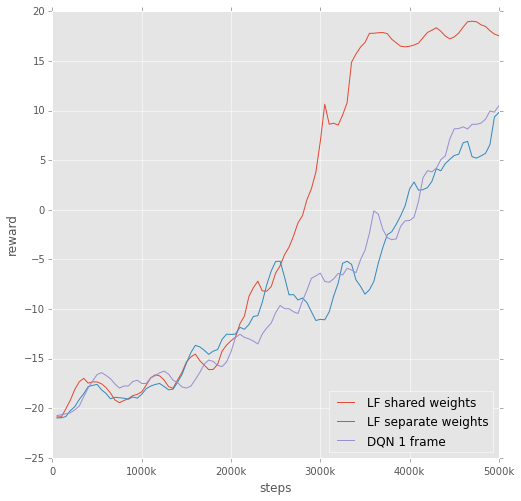

In [153]:
confidence = 0.9
#factor for given confidence and number of trials
t = stats.t._ppf((1+confidence)/2., num_reps-1)
s = partial(smoothing, window=5)

fig = plt.figure(figsize=(8,8))
epochs = np.arange(1, num_epochs + 1)
steps = epochs * 50000

ax = fig.add_subplot(111)
ax.plot(steps, s(late_fusion_rewards_mean['late_fusion_4_share-pong']),
       label='LF shared weights')
ax.plot(steps, s(late_fusion_rewards_mean['late_fusion_4_noshare-pong']),
       label='LF separate weights')
ax.plot(steps, s(single_rewards_mean), label='DQN 1 frame')

fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labelify(labels))

ax.set_xlabel('steps')
ax.set_ylabel('reward')

plt.legend(loc='lower right')
